In [2]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import rdDepictor
rdDepictor.SetPreferCoordGen(True)
import os
import json
import uuid

import rdkit
print(rdkit.__version__)
%load_ext sql
import lwreg
from lwreg import standardization_lib
from lwreg import utils
import psycopg2
import pandas as pd
import psycopg2
hostname = 'scotland'
dbname = 'cs_mdfps'
username = 'cschiebroek'
cn = psycopg2.connect(host=hostname, dbname=dbname, user=username)
cur = cn.cursor()



2023.03.3


In [5]:
cur.execute("SELECT * FROM cs_mdfps_schema.experimental_data")
experimental_data = cur.fetchall()
experimental_data[0]
molregnos = [x[0] for x in experimental_data]
print(len(molregnos))
print(len(set(molregnos)))


3078
3078


In [13]:
cur.execute("SELECT * FROM conformers")
conformers = cur.fetchall()
print(conformers[0])
molregnos = [x[1] for x in conformers]
print(len(molregnos))
print(len(set(molregnos)))

(2388, 2390, '-0.281,0.157,-0.303;-1.757,0.179,-0.498;-2.284,1.506,-0.003;-2.427,-0.953,0.272;0.093,0.307,1.115;0.407,-1.019,-0.954;1.387,0.218,1.405;1.883,-0.863,-0.822;2.306,-0.018,0.314;3.505,0.511,0.343', '[H]C([H])=C1C([H])=C([H])[C@]([H])(C([H])(C([H])([H])[H])C([H])([H])[H])C([H])([H])C1([H])[H]\n     RDKit          3D\n\n  0  0  0  0  0  0  0  0  0  0999 V3000\nM  V30 BEGIN CTAB\nM  V30 COUNTS 10 10 0 0 0\nM  V30 BEGIN ATOM\nM  V30 1 C 3.504903 0.510746 0.342615 0\nM  V30 2 C 2.305884 -0.017947 0.313519 0\nM  V30 3 C 1.386762 0.217584 1.405386 0\nM  V30 4 C 0.093030 0.307013 1.115199 0\nM  V30 5 C -0.280772 0.156627 -0.302815 0 CFG=2\nM  V30 6 C -1.757313 0.178518 -0.497845 0\nM  V30 7 C -2.426833 -0.952773 0.272219 0\nM  V30 8 C -2.284437 1.506201 -0.002609 0\nM  V30 9 C 0.407432 -1.019146 -0.953583 0\nM  V30 10 C 1.882801 -0.862709 -0.821664 0\nM  V30 END ATOM\nM  V30 BEGIN BOND\nM  V30 1 2 1 2\nM  V30 2 1 2 3\nM  V30 3 2 3 4\nM  V30 4 1 4 5\nM  V30 5 1 5 6 CFG=1\nM  V30 6 1 

In [16]:
#get duplicates from molregnos
import collections
duplicates = [item for item, count in collections.Counter(molregnos).items() if count > 1]
duplicates
#for these duplicates, get the conformer ids
cur.execute("SELECT * FROM conformers WHERE molregno IN %s", (tuple(duplicates),))
duplicates_hits = cur.fetchall()
len(duplicates_hits)

8

In [21]:
duplicates

[1066, 2680, 2709, 3461]

In [24]:
#get the molblocks for these conformers
cur.execute("SELECT * FROM conformers WHERE molregno IN %s", (tuple(duplicates),))
molblocks = cur.fetchall()
print(len(molblocks))
molblocks[0]

8


(2210,
 1066,
 '-1.143,-0.258,-0.108;-2.152,0.661,0.041;0.218,0.32,0.121;0.383,0.848,1.394;1.273,-0.726,-0.189;2.906,-0.046,0.082',
 '[H]OC([H])([H])[C@@]([H])(O[H])C([H])([H])Cl\n     RDKit          3D\n\n  0  0  0  0  0  0  0  0  0  0999 V3000\nM  V30 BEGIN CTAB\nM  V30 COUNTS 6 5 0 0 0\nM  V30 BEGIN ATOM\nM  V30 1 O -2.151684 0.661369 0.041142 0\nM  V30 2 C -1.142661 -0.258236 -0.108304 0\nM  V30 3 C 0.218158 0.320378 0.120949 0 CFG=1\nM  V30 4 O 0.382729 0.847879 1.394453 0\nM  V30 5 C 1.273060 -0.725893 -0.189196 0\nM  V30 6 Cl 2.905691 -0.045681 0.081595 0\nM  V30 END ATOM\nM  V30 BEGIN BOND\nM  V30 1 1 1 2\nM  V30 2 1 2 3\nM  V30 3 1 3 4 CFG=1\nM  V30 4 1 3 5\nM  V30 5 1 5 6\nM  V30 END BOND\nM  V30 END CTAB\nM  END\n')

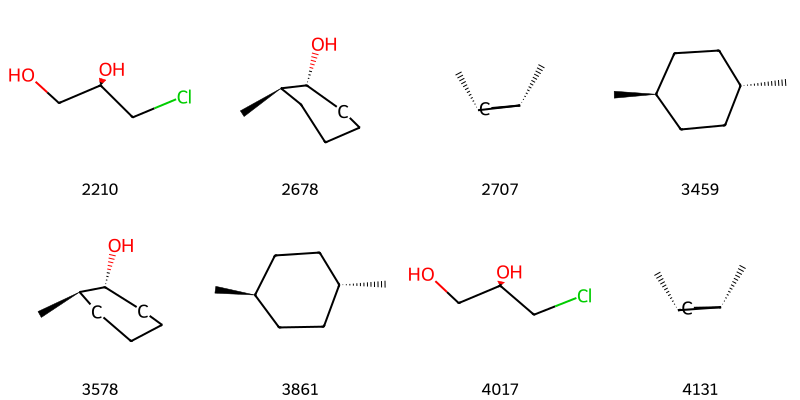

In [54]:
#make mols and draw in rdkit
mols = [Chem.MolFromMolBlock(x[3]) for x in molblocks]
confids = [x[0] for x in molblocks]
molregnos = [x[1] for x in molblocks]
Draw.MolsToGridImage(mols, molsPerRow=4,legends=[f'{x}, {y}' for x,y in zip(molregnos, confids)])

In [34]:
#for these mols, generate a conformer with the setting we used before and see if they are the same to either of the two
#conformers we already have
from rdkit.Chem import AllChem
from rdkit.Chem import rdmolops
def create_conf(smi):
    mol = Chem.AddHs(Chem.MolFromSmiles(smi, sanitize=False))
    AllChem.EmbedMolecule(mol, enforceChirality=True, randomSeed=0xf00d)
    rdmolops.AssignStereochemistryFrom3D(mol)
    used_smiles = Chem.MolToSmiles(mol, isomericSmiles=True)
    mol.SetProp("_Name", used_smiles)
    mol.UpdatePropertyCache(strict=False)
    return mol


In [32]:
#get the orignal smiles for these molregnos: this is in the experimental_data table
cur.execute("SELECT * FROM cs_mdfps_schema.experimental_data WHERE molregno IN %s", (tuple(duplicates),))
data_duplicates = cur.fetchall()
metadata_duplicates = [x[4] for x in data_duplicates]
smiles_duplicates = [x['SMILES'] for x in metadata_duplicates]
smiles_duplicates

['[OH]-[CH2]-[C@@H](-[OH])-[CH2]-[Cl]',
 '[CH3]-[C@@H]1-[CH2]-[CH2]-[CH2]-[CH2]-[C@H]-1-[OH]',
 '[CH3]-[CH]1-[CH2]-[CH]-1-[CH3]',
 '[CH3]-[CH]1-[CH2]-[CH2]-[CH](-[CH3])-[CH2]-[CH2]-1']

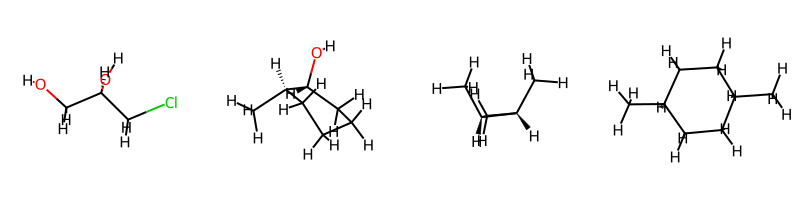

In [35]:
mols_duplicates = [create_conf(x) for x in smiles_duplicates]
Draw.MolsToGridImage(mols_duplicates, molsPerRow=4)
#now check if these are the same as the ones we already have
#first get the molblocks of the ones we already have



1 4 0.1161369521111813
3 5 0.13369320694137046
0 6 0.030528523203447948
2 7 0.04649973757937333


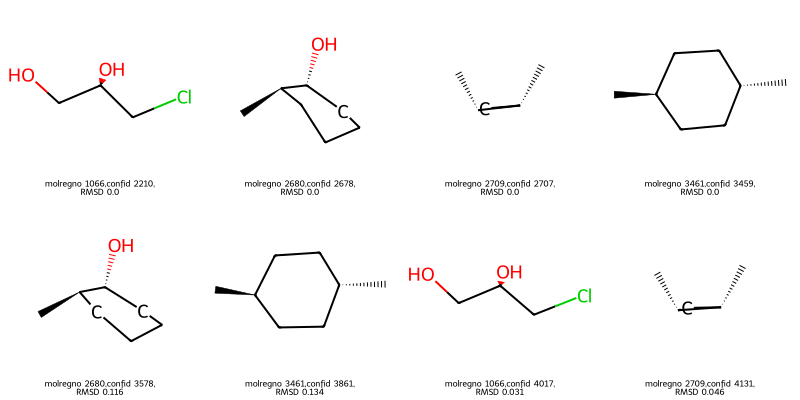

In [60]:
from rdkit.Chem import rdMolAlign
import numpy as np
#align the mols
rmsds = []
mols_duplicates_noH = [Chem.RemoveHs(x) for x in mols_duplicates]
idx_wrong_duplicates = []
for j,m2 in enumerate(mols):
    for i,m1 in enumerate(mols_duplicates_noH):
        if Chem.MolToSmiles(m1) == Chem.MolToSmiles(m2):
            rmsd = rdMolAlign.AlignMol(m1, m2)
            if rmsd > 0.00001:
                print(i, j, rmsd)
                idx_wrong_duplicates.append(j)
            rmsds.append(rmsd)
rmsds = [np.round(x, 3) for x in rmsds] 
#now draw again mols but with rmsd as legend
Draw.MolsToGridImage(mols, molsPerRow=4, legends=[f'molregno {a},confid {x},\nRMSD {y}' for a,x,y in zip(molregnos,confids, rmsds)])

In [68]:
#remove the ones that are wrong from conformers table
molregnos_wrong = [molregnos[x] for x in idx_wrong_duplicates]
confids_wrong = [confids[x] for x in idx_wrong_duplicates]
for x,y in zip(confids_wrong, molregnos_wrong):
    print(x,y)
    cur.execute("DELETE FROM conformers WHERE conf_id = %s AND molregno = %s", (x,y))

3578 2680
3861 3461
4017 1066
4131 2709


In [69]:
cn.commit()

In [75]:
cn.commit()

In [74]:
#also remove these from the cs_mdfps_schema.mdfp_experiment_data table
for x in confids_wrong:
    print(x)
    cur.execute("DELETE FROM cs_mdfps_schema.mdfp_experiment_data WHERE confid = %s", (x,))


3578
3861
4017
4131


In [98]:
#check again: are there duplicates in conformers table?
cn = psycopg2.connect(host=hostname, dbname=dbname, user=username)
cur = cn.cursor()
cur.execute("SELECT * FROM conformers")
conformers = cur.fetchall()
print(conformers[0])
molregnos = [x[1] for x in conformers]
print(len(molregnos))
print(len(set(molregnos)))
#no, good. now lets check if all is well with the mdfp_experiment_data table
cur.execute("SELECT confid FROM cs_mdfps_schema.mdfp_experiment_data")
confids_with_mdfp = cur.fetchall()
print(len(confids_with_mdfp))
#now get molregnos from conformers table
cur.execute("SELECT conf_id FROM conformers")
conf_registered = cur.fetchall()
print(len(conf_registered))


(2388, 2390, '-0.281,0.157,-0.303;-1.757,0.179,-0.498;-2.284,1.506,-0.003;-2.427,-0.953,0.272;0.093,0.307,1.115;0.407,-1.019,-0.954;1.387,0.218,1.405;1.883,-0.863,-0.822;2.306,-0.018,0.314;3.505,0.511,0.343', '[H]C([H])=C1C([H])=C([H])[C@]([H])(C([H])(C([H])([H])[H])C([H])([H])[H])C([H])([H])C1([H])[H]\n     RDKit          3D\n\n  0  0  0  0  0  0  0  0  0  0999 V3000\nM  V30 BEGIN CTAB\nM  V30 COUNTS 10 10 0 0 0\nM  V30 BEGIN ATOM\nM  V30 1 C 3.504903 0.510746 0.342615 0\nM  V30 2 C 2.305884 -0.017947 0.313519 0\nM  V30 3 C 1.386762 0.217584 1.405386 0\nM  V30 4 C 0.093030 0.307013 1.115199 0\nM  V30 5 C -0.280772 0.156627 -0.302815 0 CFG=2\nM  V30 6 C -1.757313 0.178518 -0.497845 0\nM  V30 7 C -2.426833 -0.952773 0.272219 0\nM  V30 8 C -2.284437 1.506201 -0.002609 0\nM  V30 9 C 0.407432 -1.019146 -0.953583 0\nM  V30 10 C 1.882801 -0.862709 -0.821664 0\nM  V30 END ATOM\nM  V30 BEGIN BOND\nM  V30 1 2 1 2\nM  V30 2 1 2 3\nM  V30 3 2 3 4\nM  V30 4 1 4 5\nM  V30 5 1 5 6 CFG=1\nM  V30 6 1 

In [5]:
#maybe we can join conformers and mdfp_experiment_data table to get the molregnos 
cur.execute("SELECT * FROM cs_mdfps_schema.mdfp_experiment_data JOIN conformers ON cs_mdfps_schema.mdfp_experiment_data.confid = conformers.conf_id")
conf_registered = cur.fetchall()


In [6]:
len(conf_registered)
conf_registered[0]
molregnos = [x[6] for x in conf_registered]
molregnos[0]
print(len(molregnos))
print(len(set(molregnos)))
#get duplicates 
import collections
duplicates = [item for item, count in collections.Counter(molregnos).items() if count > 1]
#show these in the table
cur.execute("SELECT * FROM cs_mdfps_schema.mdfp_experiment_data JOIN conformers ON cs_mdfps_schema.mdfp_experiment_data.confid = conformers.conf_id WHERE molregno IN %s", (tuple(duplicates),))
duplicates_hits = cur.fetchall()


3027
3023


In [7]:
len(duplicates_hits)
duplicates_hits[0]
confids_of_duplicates = list(set([x[0] for x in duplicates_hits]))
confids_of_duplicates

[2400, 2388, 1150, 1151]

In [8]:
cn = psycopg2.connect(host=hostname, dbname=dbname, user=username)
cur = cn.cursor()
for confid_duplicate in confids_of_duplicates:
    #get the entries
    cur.execute("SELECT * FROM cs_mdfps_schema.mdfp_experiment_data WHERE confid = %s", (confid_duplicate,))
    entries = cur.fetchall()
    #for the second entry, get the mdfp_conf_uuid
    mdfp_conf_uuid = entries[1][3]
    print(mdfp_conf_uuid)
    #delete this entry from the table
    cur.execute("DELETE FROM cs_mdfps_schema.mdfp_experiment_data WHERE mdfp_conf_uuid = %s", (mdfp_conf_uuid,))
#now check again if there are duplicate confids in the table
cur.execute("SELECT * FROM cs_mdfps_schema.mdfp_experiment_data")
duplicates_hits = cur.fetchall()
conifds = [x[0] for x in duplicates_hits]
print(len(conifds))
print(len(set(conifds)))


2473aa2c-c674-4a52-b6ba-d1023521ebd1
825bcd72-5b23-4134-a449-5eccb1552474
f3c35cb6-e3a0-43fe-961f-a61782479cda
8eeff292-caf4-42a3-bd13-e1afc11e0b69
3023
3023


In [9]:
cn.commit()

In [124]:
#okay, the data is now clean! congratulations.
#now we have to register the missing entries (maybe these are stereoisomers?), fix simulation errors and run missing entries.
#lets start by just grabbing the missing entries; we can do this by getting all the smiles (from vp_metadata) and comparing them to the pandas df
#first get the smiles from the vp_metadata table
cur.execute("SELECT vp_metadata FROM cs_mdfps_schema.experimental_data")
vp_metadata = cur.fetchall()
registered_SMILES = [x[0]['SMILES'] for x in vp_metadata]
import pandas as pd
df = pd.read_csv('/localhome/cschiebroek/ShuZe/vp/data cleaning/cleaned_vp_all.tsv', sep='\t')
df = df[df['Temperature'] == 298.15 ]
print(len(df))
smiles_with_exp_vp = df['SMILES'].tolist()
#now compare the two lists
missing_smiles = [x for x in smiles_with_exp_vp if x not in registered_SMILES]
print(len(missing_smiles))


3098
20


In [125]:
import lwreg
from lwreg import standardization_lib
from lwreg import utils
config = lwreg.utils.defaultConfig()
# set the name of the database we'll work with:
config['dbtype'] = 'postgresql'
config['dbname'] = 'cs_mdfps'
config['host'] = 'scotland'
config['user'] = 'cschiebroek'
config['password'] = '' # password is saved in our .pgpass
# we don't want to standardize the molecules:
config['standardization'] = standardization_lib.RemoveHs()
# we want to store conformers
config['registerConformers'] = True

In [126]:
#lets just try to register one using lwreg.
from rdkit.Chem import AllChem
from rdkit.Chem import rdmolops
missing_mols_with_conf = []
missing_smiles_with_conf = []
for smi in missing_smiles:
    mol = Chem.AddHs(Chem.MolFromSmiles(smi, sanitize=False))
    conf_gen = AllChem.EmbedMolecule(mol, enforceChirality=True, randomSeed=0xf00d)
    rdmolops.AssignStereochemistryFrom3D(mol)
    used_smiles = Chem.MolToSmiles(mol, isomericSmiles=True)
    mol.SetProp("_Name", used_smiles)
    mol.UpdatePropertyCache(strict=False)
    if conf_gen == -1:
        print('no conformer generated')
    else:
        print('conformer generated')
        missing_mols_with_conf.append(mol)
        missing_smiles_with_conf.append(smi)

no conformer generated
conformer generated
conformer generated
conformer generated
no conformer generated
conformer generated
conformer generated
conformer generated
conformer generated
conformer generated
conformer generated
no conformer generated
conformer generated
conformer generated
no conformer generated
conformer generated
conformer generated
conformer generated
conformer generated
conformer generated


In [127]:
#wait, we can query on mols! lets do that
entries = []
missing_smiles_with_conf_registered = []
for mol,smiles in zip(missing_mols_with_conf, missing_smiles_with_conf):
    query = lwreg.query(config=config, mol=mol)
    if len(query) == 0:
        continue
    else:
        entries.append(query)
        missing_smiles_with_conf_registered.append(smiles)
entries


[[(84, 1227)],
 [(1046, 2190)],
 [(273, 1418)],
 [(249, 1394)],
 [(2491, 2489)],
 [(602, 1747)],
 [(98, 1243)],
 [(3358, 3356)],
 [(914, 2059)],
 [(4098, 4096)],
 [(2464, 2462)],
 [(2327, 2325)]]

In [129]:
cn = psycopg2.connect(host=hostname, dbname=dbname, user=username)
cur = cn.cursor()
molregnos = []
for entry in entries:
    if entry:
        molregnos.append(entry[0][0])
smiles_registerd = []
for molregno in molregnos:
    cur.execute("SELECT * FROM cs_mdfps_schema.experimental_data WHERE molregno = %s", (molregno,))
    data = cur.fetchall()
    smiles_registerd.append(data[0][4]['SMILES'])

In [130]:
import numpy as np
smiles_to_remove = []
for i,j in zip(missing_smiles_with_conf_registered, smiles_registerd):
    vps = df[df['SMILES'].isin([i,j])]['Vapour Pressure (log10 kPa)'].tolist()
    #if difference is bigger then 0.01 (as described in manuscript ShuZe), its too much and entry should be removed
    if abs(vps[0] - vps[1]) > 0.01 * np.mean(vps):
        smiles_to_remove.append(j)
        df = df.drop(df[df['SMILES'] == i].index)
        df = df.drop(df[df['SMILES'] == j].index)
    else:
        df = df.drop(df[df['SMILES'] == i].index)
print(len(df))



3078


In [134]:
smiles_to_remove[0]

'[CH]1=[CH]-[CH2]-[CH2]-[CH]=[CH]-[CH2]-[CH2]-1'

In [147]:
smiles_to_remove
cur.execute("SELECT * FROM cs_mdfps_schema.experimental_data")
vp_metadata = cur.fetchall()
data_to_delete = [x for x in vp_metadata if x[4]['SMILES'] in smiles_to_remove]
molregnos_to_delete = [x[0] for x in data_to_delete]
molregnos_to_delete

[84, 249, 273, 914, 1046, 2491, 3358, 4098]

In [151]:
#okay, so for these, we need to get the confids, then we need to delete the entries from the mdfp_experiment_data (on confid) and from conformers (on confid and molregno) and from experimental_data (on molregno)
#get confids: 
hits = lwreg.query(config=config, ids=molregnos_to_delete)
print(hits)
confids = [x[1] for x in hits]
confids


[(84, 1227), (249, 1394), (273, 1418), (914, 2059), (1046, 2190), (2491, 2489), (3358, 3356), (4098, 4096)]


[1227, 1394, 1418, 2059, 2190, 2489, 3356, 4096]

In [152]:
for x in confids:
    print(x)
    cur.execute("DELETE FROM cs_mdfps_schema.mdfp_experiment_data WHERE confid = %s", (x,))

1227
1394
1418
2059
2190
2489
3356
4096


In [153]:
cn.commit()

In [154]:
for x in molregnos_to_delete:
    print(x)
    cur.execute("DELETE FROM cs_mdfps_schema.experimental_data WHERE molregno = %s", (x,))
    cur.execute("DELETE FROM conformers WHERE molregno = %s", (x,))

84
249
273
914
1046
2491
3358
4098


In [155]:
cn.commit()

In [159]:
#okay! we got these out of the way. lets see where we stand now. lets save the df as a tsv
df.to_csv('cleaned_vp_all_298_no_dups.tsv', sep='\t')
#get all the smiles from the df
smiles = df['SMILES'].tolist()
print(len(smiles))
#get all the smiles from experimental_data
cur.execute("SELECT * FROM cs_mdfps_schema.experimental_data")
experimental_data = cur.fetchall()
smiles_registered = [x[4]['SMILES'] for x in experimental_data]
print(len(smiles_registered))
smiles_still_missing = [x for x in smiles if x not in smiles_registered]
print(len(smiles_still_missing))



3078
3070
8


In [166]:
#some of these should still have confs;
#lets just try to register one using lwreg.
from rdkit.Chem import AllChem
from rdkit.Chem import rdmolops
still_missing_mols_with_conf = []
still_missing_smiles_with_conf = []
print(len(smiles_still_missing))
for smi in smiles_still_missing:
    mol = Chem.AddHs(Chem.MolFromSmiles(smi, sanitize=False))
    conf_gen = AllChem.EmbedMolecule(mol, enforceChirality=True, randomSeed=0xf00d)
    if conf_gen == -1:
        print('no conformer generated')
        continue
    rdmolops.AssignStereochemistryFrom3D(mol)
    used_smiles = Chem.MolToSmiles(mol, isomericSmiles=True)
    mol.SetProp("_Name", used_smiles)
    mol.UpdatePropertyCache(strict=False)
    print('conformer generated')
    still_missing_mols_with_conf.append(mol)
    still_missing_smiles_with_conf.append(smi)
print(len(still_missing_smiles_with_conf))

8
no conformer generated
no conformer generated
conformer generated
no conformer generated
conformer generated
conformer generated
no conformer generated
conformer generated
4


In [167]:
#lets try to register one of these
mol = still_missing_mols_with_conf[0]
lwreg.register(config=config, mol=mol)

(2680, 4248)

In [168]:
still_missing_mols_with_conf_to_add = still_missing_mols_with_conf[1:]
lwreg.bulk_register(config=config, mols=still_missing_mols_with_conf_to_add)

((3461, 4249), (1066, 4250), (2709, 4251))

4


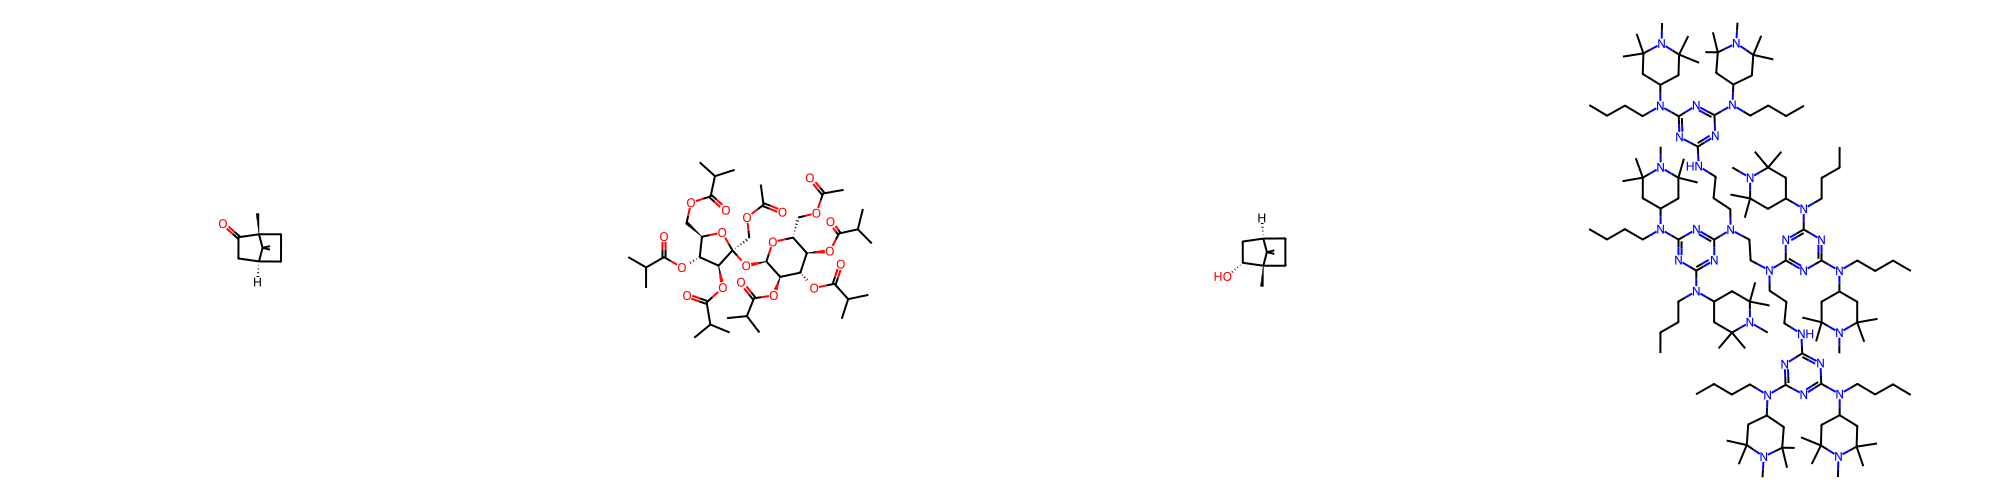

In [172]:
#great! these are added now. now we need to look at the ones for which conformers could not be generated, and then add all the experimental data for these
failed_conf_gen_smiles = [x for x in smiles_still_missing if x not in still_missing_smiles_with_conf]
print(len(failed_conf_gen_smiles))
#make mols and draw in rdkit
mols = [Chem.MolFromSmiles(x) for x in failed_conf_gen_smiles]
Draw.MolsToGridImage(mols, molsPerRow=4,subImgSize=(500,500))
#stunning. We could try again with either different seed, or with more attempts.


In [178]:
from rdkit.Chem import rdDistGeom

def print_failure_causes(counts):
    for i,k in enumerate(rdDistGeom.EmbedFailureCauses.names):
        print(k,counts[i])
    # in v2022.03.1 two names are missing from `rdDistGeom.EmbedFailureCauses`:
    print('LINEAR_DOUBLE_BOND',counts[i+1])
    print('BAD_DOUBLE_BOND_STEREO',counts[i+2]) 

In [180]:
#lets just try to register one using lwreg.
mols_failed_confgen = []
ps = rdDistGeom.ETKDGv3()
ps.randomSeed = 0xf00d
ps.trackFailures = True
for smi in failed_conf_gen_smiles:
    mol = Chem.AddHs(Chem.MolFromSmiles(smi, sanitize=False))
    ps = rdDistGeom.ETKDGv3()
    ps.randomSeed = 0xf00d
    ps.trackFailures = True
    print(rdDistGeom.EmbedMolecule(mol, ps))
    counts = ps.GetFailureCounts()
    print('\n---------------------------\n')
    print_failure_causes(counts)
    print('\n---------------------------\n')

-1

---------------------------

INITIAL_COORDS 9
FIRST_MINIMIZATION 0
CHECK_TETRAHEDRAL_CENTERS 170
CHECK_CHIRAL_CENTERS 0
MINIMIZE_FOURTH_DIMENSION 0
ETK_MINIMIZATION 0
FINAL_CHIRAL_BOUNDS 91
FINAL_CENTER_IN_VOLUME 0
LINEAR_DOUBLE_BOND 0
BAD_DOUBLE_BOND_STEREO 0


IndexError: tuple index out of range

In [ ]:
#lets make a df with these entries and save it. we can always come back to it later
df_failed = df[df['SMILES'].isin(failed_conf_gen_smiles)]
df_failed.to_csv('vp_298_failed_confgen.tsv', sep='\t')
#and remove these from the df
df = df.drop(df[df['SMILES'].isin(failed_conf_gen_smiles)].index)
#save the new df
df.to_csv('cleaned_vp_all_298_no_dups.tsv', sep='\t')

In [205]:
#lets check where we are now:
cur.execute("SELECT vp_metadata FROM cs_mdfps_schema.experimental_data")
vp_metadata = cur.fetchall()
df = pd.read_csv('cleaned_vp_all_298_no_dups.tsv', sep='\t')
registered_SMILES = [x[0]['SMILES'] for x in vp_metadata]
print(len(df))
smiles_with_exp_vp = df['SMILES'].tolist()
#now compare the two lists
missing_smiles = [x for x in smiles_with_exp_vp if x not in registered_SMILES]
print(len(missing_smiles))


3074
4


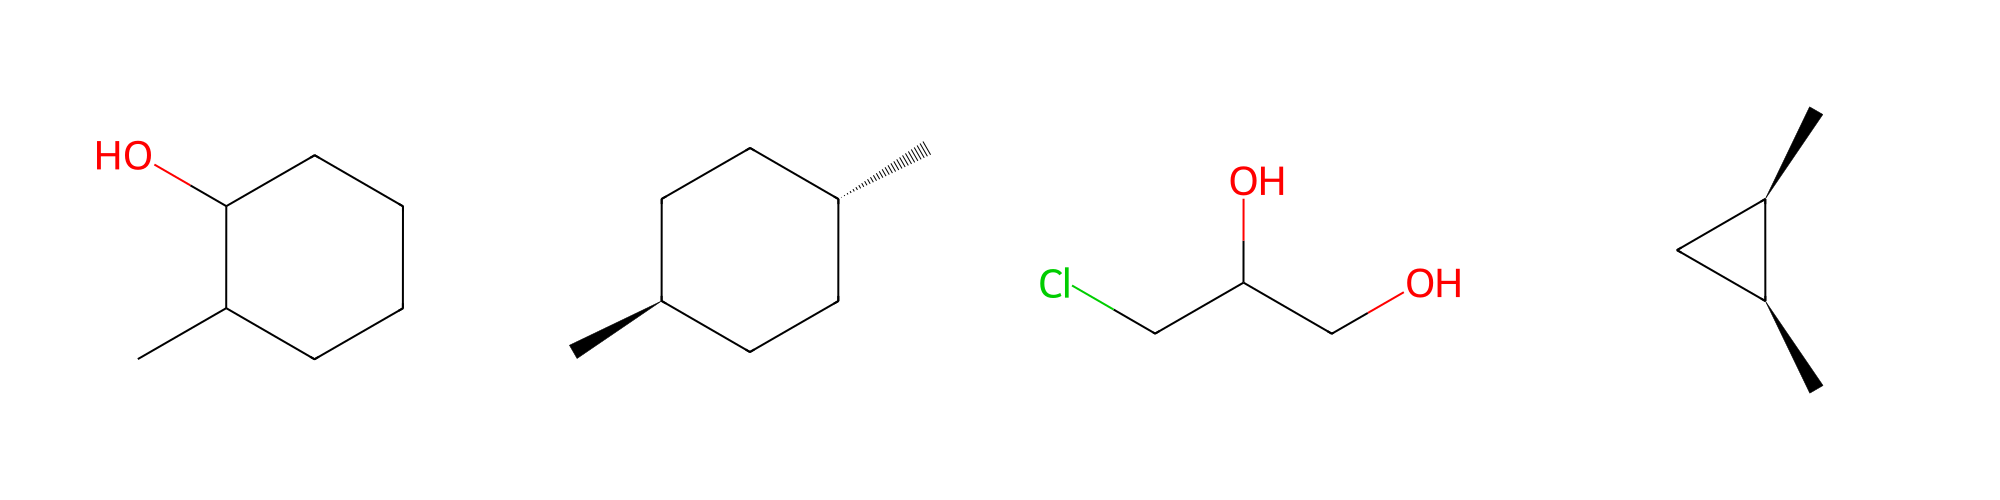

In [206]:
#draw these mols
mols = [Chem.MolFromSmiles(x) for x in missing_smiles]
Draw.MolsToGridImage(mols, molsPerRow=4,subImgSize=(500,500))
#where this not already registered? lets see if we can retrieve


In [207]:
for mol in mols:
    print(lwreg.query(config=config, mol=mol))

[]
[3461]
[]
[2709]


In [210]:
#okay, so they are not registered yet, and confs should work. Kind of weird but lets register I guess
last_missing_mols_with_conf = []
last_missing_smiles_with_conf = []
molregnos_to_look_at = []
print(len(missing_smiles))
for smi in missing_smiles:
    mol = Chem.AddHs(Chem.MolFromSmiles(smi, sanitize=False))
    conf_gen = AllChem.EmbedMolecule(mol, enforceChirality=True, randomSeed=0xf00d)
    if conf_gen == -1:
        print('no conformer generated')
        continue
    rdmolops.AssignStereochemistryFrom3D(mol)
    used_smiles = Chem.MolToSmiles(mol, isomericSmiles=True)
    mol.SetProp("_Name", used_smiles)
    mol.UpdatePropertyCache(strict=False)
    print('conformer generated')
    last_missing_mols_with_conf.append(mol)
    last_missing_smiles_with_conf.append(smi)
    query = lwreg.query(config=config, mol=mol)
    print(query)
    molregno = query[0][0]
    molregnos_to_look_at.append(molregno)
molregnos_to_look_at

4
conformer generated
[(2680, 4248)]
conformer generated
[(3461, 4249)]
conformer generated
[(1066, 4250)]
conformer generated
[(2709, 4251)]


[2680, 3461, 1066, 2709]

In [218]:
#so these mols are all already registerd? --> they have to be duplicates in the df itself I guess? or is my brain just fried?
#so we already have the smiles, and the molregnos of the ones that are supposedly missing. we can just get those smiles too simly 
cur.execute("SELECT * FROM cs_mdfps_schema.experimental_data WHERE molregno IN %s", (tuple(molregnos_to_look_at),))
data = cur.fetchall()
smiles_registered = [x[4]['SMILES'] for x in data]
smiles_registered
#change order from 0 1 2 3 to 1 3 0 2
smiles_registered = [smiles_registered[1], smiles_registered[3], smiles_registered[0], smiles_registered[2]]
smiles_registered

['[CH3]-[C@@H]1-[CH2]-[CH2]-[CH2]-[CH2]-[C@H]-1-[OH]',
 '[CH3]-[CH]1-[CH2]-[CH2]-[CH](-[CH3])-[CH2]-[CH2]-1',
 '[OH]-[CH2]-[C@@H](-[OH])-[CH2]-[Cl]',
 '[CH3]-[CH]1-[CH2]-[CH]-1-[CH3]']

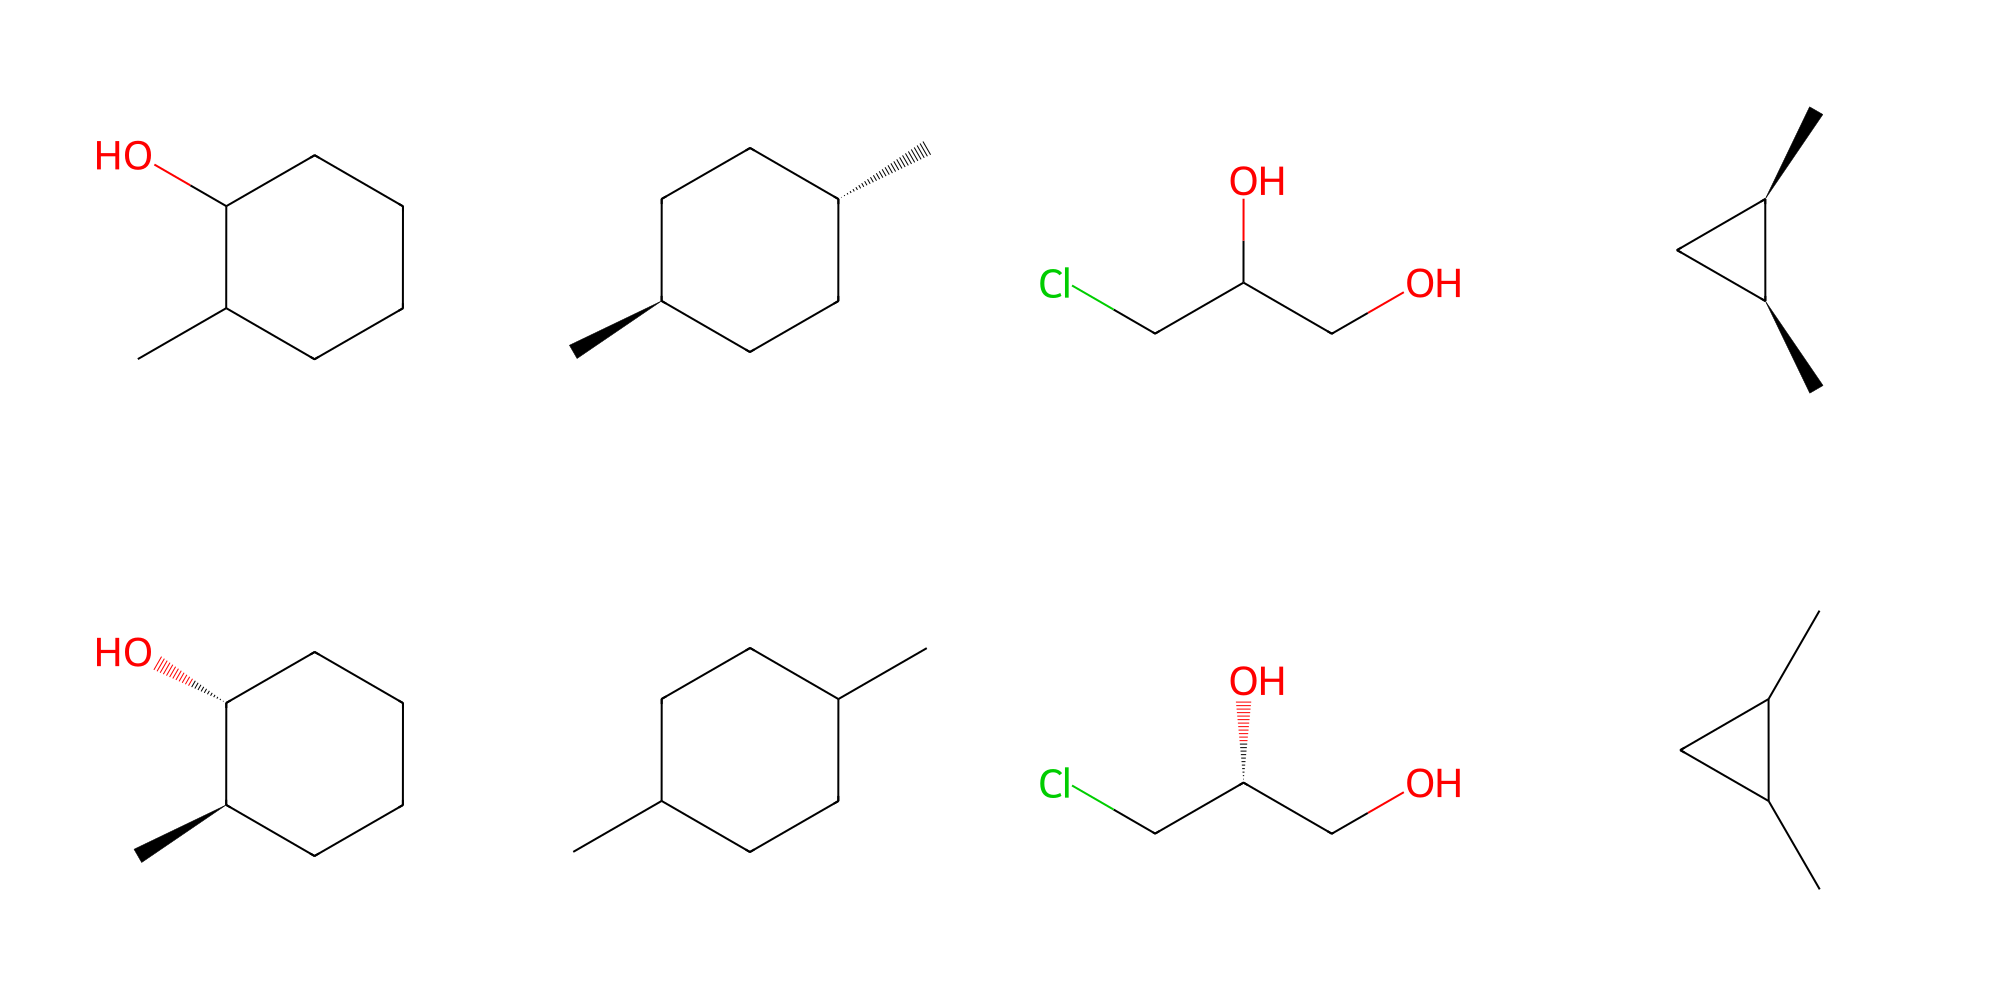

In [219]:
missing_smiles
together = missing_smiles + smiles_registered
together_mols = [Chem.MolFromSmiles(x) for x in together]
Draw.MolsToGridImage(together_mols, molsPerRow=4,subImgSize=(500,500))

In [225]:
#aha, so some have stereo specified, others do not. lets look at the df entries.
pairs = []
for s1, s2 in zip(smiles_registered,missing_smiles):
    pairs.append([s1,s2])
    vps = df[df['SMILES'].isin([s1,s2])]['Vapour Pressure (log10 kPa)'].tolist()
    if abs(vps[0] - vps[1]) > 0.01:
        print('too big difference:' ,np.round(abs(vps[0] - vps[1]),3),np.round(vps[0],3), np.round(vps[1],3))

too big difference: 0.202 -0.798 -1.0
too big difference: 0.102 0.378 0.48
too big difference: 1.597 -2.658 -1.06
too big difference: 0.129 1.959 1.829


In [227]:
#make df with these entries, save it to look at later
df_to_look_at = df[df['SMILES'].isin(together)]
df_to_look_at.to_csv('vp_298_to_look_at.tsv', sep='\t')

In [230]:
# #same story as before here:

molregnos_to_look_at
hits = lwreg.query(config=config, ids=molregnos_to_look_at)
print(hits)
confids = [x[1] for x in hits]
confids
#I see, I guess we have have two conformers for each molregno, that makes it a bit more complicated.

[(1066, 2210), (2680, 2678), (2709, 2707), (3461, 3459), (2680, 4248), (3461, 4249), (1066, 4250), (2709, 4251)]


[2210, 2678, 2707, 3459, 4248, 4249, 4250, 4251]

In [ ]:
#okay now the question is, do we fully delete, or only keep with specified stereo?
#to answer this, we must know: should stereo be important for the vp?
#also damn these differences are really big, I wonder what the experimental ucertainty is; i.e. how good could our model possibly get? check the post from Pat Walters!!
#I think for these compounds, stereo should not heavily impact vp; the molecular size and intramolecular forces should be somewhat similar for the two stereoisomers

